# Assignment 4

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

This assignment requires that you to find **at least** two datasets on the web which are related, and that you visualize these datasets to answer a question with the broad topic of **weather phenomena** (see below) for the region of **Santiago, Santiago Metropolitan, Chile**, or **Chile** more broadly.

You can merge these datasets with data from different regions if you like! For instance, you might want to compare **Santiago, Santiago Metropolitan, Chile** to Ann Arbor, USA. In that case at least one source file must be about **Santiago, Santiago Metropolitan, Chile**.

You are welcome to choose datasets at your discretion, but keep in mind **they will be shared with your peers**, so choose appropriate datasets. Sensitive, confidential, illicit, and proprietary materials are not good choices for datasets for this assignment. You are welcome to upload datasets of your own as well, and link to them using a third party repository such as github, bitbucket, pastebin, etc. Please be aware of the Coursera terms of service with respect to intellectual property.

## 1 Region and Domain

I am going to study the air temperature (Celsius degrees) and pollution (PM 2.5) in two regions:
* Ann Arbor, MI, United States
* Santiago, RM, Chile.

The studied field are weather and pollution.


## 2 Research Question

The objective is show the temperatures and outdoor air quality the last year. To do this, I do the following analysis

* Compare extreme temperatures between cities
* Compare daily pollution (measured by PM 2.5). 

To do a hypothesis I consider the population in both cities

* Population in Santiago (2019): 6.724 MM
* Population in Ann Arbor (2019): 113.988

Another variable is the coordinates in both cities 
* Location in Santiago: 33.4489° S, 70.6693° W
* Location in Ann Arbor: 42.2808° N, 83.7430° W

The intuitive hypothesis is the weather is less variable when the city is farther of poles and the population is a key factor to pollution measures.

## Datasets

* Air Temperature and pollution in Santiago, Chile [Parque O'higgins Station](https://sinca.mma.gob.cl/index.php/estacion/index/id/273)
* Pollution in Ann Arbor, MI, USA [Pollutant: PM2.5](https://www.epa.gov/outdoor-air-quality-data/air-data-tile-plot)
* Air temperature in Ann Arbor [Ann Arbor Station: 72537404889](https://www.ncei.noaa.gov/data/global-hourly/access/2019/)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.dates as dates
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [3]:
#Data range
date_index = np.arange('2019-01-01','2020-01-01', dtype='datetime64[D]')
df=pd.DataFrame(index=date_index)

#Read data from Santiago, Chile
##pollution (PM 2.5)
pm = pd.read_csv('data/assignment/PM25_CL19.csv', delimiter=';')
pm.columns=['Date', 'Hour', 'PM25Val', 'PM25Pre', 'PM25NotVal', 'Unnamed']

pm['PM25Val'].fillna(pm['PM25NotVal'], inplace=True)
pm["PM25Val"].fillna(method ='ffill', inplace = True) 
pm['Date'] = pd.to_datetime(pm.Date, format='%y%m%d')
pm = pm[['Date', 'PM25Val']]
pm.columns=['Date', 'PM25']

##Temperature
temp = pd.read_csv('data/assignment/TEMP_CL19.csv', delimiter=';', decimal=',')
temp.columns=['Date', 'Hour', 'Temp', 'Temp02']
temp = temp.dropna(subset=['Temp'])
temp =temp.set_index('Date').groupby(level=0).agg({'Temp': ['min','mean','max']})
temp.columns = temp.columns.droplevel(0)
temp = temp.reset_index()
temp['Date'] = pd.to_datetime(temp.Date, format='%y%m%d')
temp.columns=['Date','TempMin','TempAvg','TempMax']

##merge databases
cl = pd.merge(df, pm, how='left', left_index=True, right_on='Date')
cl = pd.merge(cl, temp, how='left', left_on='Date', right_on='Date')
cl = cl.fillna(method='ffill')
cl['City']='Santiago, RM, Chile'

#Read data from Ann Arbor, MI, United States
##pollution (PM 2.5)
pm = pd.read_csv('data/assignment/PM25_US19.csv', delimiter=',')
pm = pm.set_index('Date').groupby(level=0).agg({'Daily Mean PM2.5 Concentration': ['max']})
pm.columns = pm.columns.droplevel(0)
pm = pm.reset_index()
pm['Date'] = pd.to_datetime(pm.Date)
pm.columns=['Date','PM25']

##Temperature
temp = pd.read_csv('data/assignment/TEMP_US19.csv', delimiter=',', low_memory=False)
temp=temp[['DATE','TMP']]
temp['Date'] = temp.apply(lambda x: x['DATE'][0:10],axis=1)
temp['Temp1'] = temp.apply(lambda x: x['TMP'][1:5],axis=1)
temp['Temp2'] = temp.apply(lambda x: x['TMP'][0],axis=1)
temp['sign'] = temp['Temp2'].apply(lambda x: 1 if x == '+' else -1)
temp['Temp'] = temp['Temp1'].astype(float)/10*temp['sign']
temp = temp[temp['Temp1'] != '9999']
temp['Date'] = pd.to_datetime(temp.Date)#, format='%y%m%d')
temp =temp.set_index('Date').groupby(level=0).agg({'Temp': ['min','mean','max']})
temp.columns = temp.columns.droplevel(0)
temp.columns=['TempMin','TempAvg','TempMax']

##merge databases
us = pd.merge(df, pm, how='left', left_index=True, right_on='Date')
us = pd.merge(us, temp, how='left', left_on='Date', right_index=True)
us = us.fillna(method='ffill')
us['City']='Ann Arbor, MI, United States'

#append databases
data = cl.append(us)

#data to make violin plot of temperature
data2=data[['TempMin','TempMax','City']]
data2=data2.set_index(['City'])
data2=data2.unstack()
data2=data2.reset_index()
data2.columns=['Type','City','Temp']

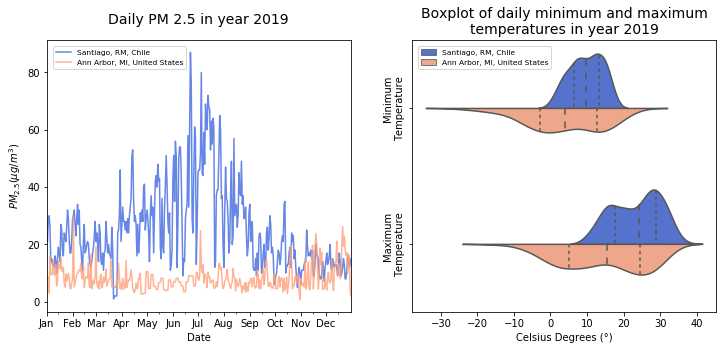

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

#  Time plot
sns.lineplot(x='Date', y='PM25', hue="City", data=data, legend=False, palette=['royalblue','lightsalmon'], alpha=0.8, ax=axes[0])
axes[0].legend(loc='upper left', labels=['Santiago, RM, Chile', 'Ann Arbor, MI, United States'], fontsize=7.5,
           bbox_to_anchor=(0.007, 0.99));
axes[0].set_ylabel(r'$PM_{2.5}(\mu g / m^3)$');
axes[0].set_xlabel('Date');
tt = axes[0].set_title("Daily PM 2.5 in year 2019", size=14);
tt.set_position([.5, 1.04])
## Format the date into months & days
axes[0].xaxis.set_major_formatter(dates.DateFormatter('%b')); 
## Limit of x-axis
axes[0].set_xlim([dt.date(2019, 1, 1), dt.date(2019, 12, 31)]);
axes[0].xaxis.set_minor_locator(dates.MonthLocator(bymonthday=15))

#  Violin plot
sns.violinplot(x="Temp", y="Type", hue="City", data=data2, palette=['royalblue','lightsalmon'], 
                   alpha=0.8, split=True, inner='quartile', ax=axes[1]);
## Axes options 
axes[1].legend(loc='upper left',fontsize=7.5, bbox_to_anchor=(0.007, 0.99));
axes[1].set_xlabel('Celsius Degrees (°)');
axes[1].set_ylabel('');
axes[1].set_title('Boxplot of daily minimum and maximum\ntemperatures in year 2019', size=14);
axes[1].set_yticklabels(['Minimum\nTemperature','Maximum\nTemperature'], rotation=90, ha='right', va='center')

plt.savefig('WeatherAssignment4.png')
plt.show()






## Conclusions

* Pollution: The pollution graph shows Santiago has more poorly air quality in 2019 than Ann Arbor, the blue line is greater than the red one on most of the days. If we observed the population in both cities, there is a reasonable because Santiago has 59 times the Ann Arbor population.
* Temperature: Relative to extreme temperatures, there is a larger variation in Ann Arbor, and the median is greater in Santiago. This is reasonable because the location could explain this difference. 